# Data Analysis

## Import Packages

In [1]:
%matplotlib inline
import re
import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

## Get Data

In [2]:
with open('movies_twenty.json') as f:
    raw_data = json.load(f)

Convert the list of reviews to a single string

In [3]:
for a in raw_data:
    string = ""
    for review in a['Reviews']:
        #print(review)
        string += str(review) + " "
    a['String'] = string

Divide ratings based on catergories

In [4]:
for a in raw_data:
    rating = a['Audience Rating']
    rating = rating.strip('%')
    rating = int(rating)
    if rating >= 75:
        a['4'] = 1
        a['3'] = 0
        a['2'] = 0
        a['1'] = 0
    elif rating >= 50:
        a['4'] = 0
        a['3'] = 1
        a['2'] = 0
        a['1'] = 0
    elif rating >= 25:
        a['4'] = 0
        a['3'] = 0
        a['2'] = 1
        a['1'] = 0
    else:
        a['4'] = 0
        a['3'] = 0
        a['2'] = 0
        a['1'] = 1

In [5]:
movie = raw_data[140]

In [6]:
print(movie['4'])

0


# Data Frame

In [7]:
data = pd.DataFrame(raw_data)

In [8]:
data.head()

,1,2,3,4,Audience Rating,Reviews,String,Title,Tomatometer,Url
0,0,0,0,1,98%,"[This film was great., My all-time favourite m...",This film was great. My all-time favourite mov...,The Godfather,98%,https://www.rottentomatoes.com/m/godfather
1,0,0,0,1,95%,[Easily the best Christmas movie of all time. ...,Easily the best Christmas movie of all time. I...,It’s a Wonderful Life,93%,https://www.rottentomatoes.com/m/its_a_wonderf...
2,0,0,0,1,95%,"[ONCE UPON A TIME IN THE WEST is a grand, poig...","ONCE UPON A TIME IN THE WEST is a grand, poign...",Once Upon A Time In The West,98%,https://www.rottentomatoes.com/m/once_upon_a_t...
3,0,0,0,1,95%,[Easily one of the best movies of all time. Fr...,Easily one of the best movies of all time. Fro...,Forrest Gump,73%,https://www.rottentomatoes.com/m/forrest_gump
4,0,0,0,1,95%,[I was blown away by Amelie even though there ...,I was blown away by Amelie even though there w...,Amélie,89%,https://www.rottentomatoes.com/m/amelie


Drop all information that is not needed 

In [9]:
data.drop(['Reviews', 'Title', 'Audience Rating','Tomatometer','Url'], 1, inplace=True)

In [10]:
data.head()

,1,2,3,4,String
0,0,0,0,1,This film was great. My all-time favourite mov...
1,0,0,0,1,Easily the best Christmas movie of all time. I...
2,0,0,0,1,"ONCE UPON A TIME IN THE WEST is a grand, poign..."
3,0,0,0,1,Easily one of the best movies of all time. Fro...
4,0,0,0,1,I was blown away by Amelie even though there w...


Exploratory Data Analysis

In [11]:
df = data.drop(['String'], axis=1)
counts = []
categories = list(df.columns.values)
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,1,6
1,2,48
2,3,44
3,4,47


([<matplotlib.axis.XTick at 0x1a1a5c9128>,
 <a list of 4 Text xticklabel objects>)

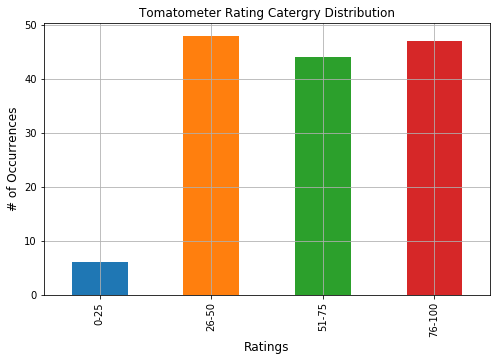

In [12]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Audience Rating Cateegory Distribution")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Ratings', fontsize=12)
plt.xticks(np.arange(4),('0-25', '26-50', '51-75','76-100'))

Ensuring that every element has a classification

In [13]:
print('Number of missing comments in comment text:')
data['String'].isnull().sum()

Number of missing comments in comment text:


0

### Lower Case

In [14]:
data['String'] = data['String'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['String'].head()

0    this film was great. my all-time favourite mov...
1    easily the best christmas movie of all time. i...
2    once upon a time in the west is a grand, poign...
3    easily one of the best movies of all time. fro...
4    i was blown away by amelie even though there w...
Name: String, dtype: object

### Strip numbers

In [15]:
data['String'] = data['String'].str.replace('[^\w\s]','')
data['String'].head()  

0    this film was great my alltime favourite movie...
1    easily the best christmas movie of all time it...
2    once upon a time in the west is a grand poigna...
3    easily one of the best movies of all time from...
4    i was blown away by amelie even though there w...
Name: String, dtype: object

### Stop Words

In [16]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [17]:
data['String'] = data['String'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['String'].head() 

0    film great alltime favourite movie intense loo...
1    easily best christmas movie time movie watch c...
2    upon time west grand poignant gloriously epic ...
3    easily one best movies time brilliant cast pow...
4    blown away amelie even though substantial hype...
Name: String, dtype: object

### Rare words

In [18]:
freq = pd.Series(' '.join(data['String']).split()).value_counts()[-50:]

In [19]:
freq = list(freq.index)
data['String'] = data['String'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data['String'].head()

0    film great alltime favourite movie intense loo...
1    easily best christmas movie time movie watch c...
2    upon time west grand poignant gloriously epic ...
3    easily one best movies time brilliant cast pow...
4    blown away amelie even though substantial hype...
Name: String, dtype: object

### Lemmatization

In [20]:
from textblob import Word
data['String'] = data['String'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['String'].head()

0    film great alltime favourite movie intense loo...
1    easily best christmas movie time movie watch c...
2    upon time west grand poignant gloriously epic ...
3    easily one best movie time brilliant cast powe...
4    blown away amelie even though substantial hype...
Name: String, dtype: object

## Divide Data into Training and Testing

In [21]:
categories = ['1', '2', '3', '4']
train, test = train_test_split(data, random_state=42, test_size=0.33, shuffle=True)
X_train = train.String
X_test = test.String
print(X_train.shape)
print(X_test.shape)

(97,)
(48,)


## Bulding the Classifiers

Define a pipeline combining a text feature extractor with multi lable classifier

In [22]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing 1
Test accuracy is 0.9375
... Processing 2
Test accuracy is 0.6666666666666666
... Processing 3
Test accuracy is 0.75
... Processing 4
Test accuracy is 0.6458333333333334


In [23]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))


... Processing 1
Test accuracy is 0.9375
... Processing 2
Test accuracy is 0.6666666666666666
... Processing 3
Test accuracy is 0.75
... Processing 4
Test accuracy is 0.7708333333333334


In [24]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing 1


/Users/nikki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.9375
... Processing 2
Test accuracy is 0.6666666666666666
... Processing 3
Test accuracy is 0.75
... Processing 4
Test accuracy is 0.6458333333333334
